In [32]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, write_biax_abaqus_inp

from jaxinterp2d import interp2d

import scipy.io

In [33]:
def nn_fpass(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    H = jnp.matmul(H, Ws[-1]) + bs[-1]
    return H

def ff_nn(x, params): #ff: fourier features
    ff_params, nn_params = params
    x = jnp.matmul(x, ff_params)
    x = jnp.hstack([jnp.sin(2*jnp.pi*x), jnp.cos(2*jnp.pi*x)])

    x = nn_fpass(x, nn_params)
    return x

def init_params_nn(layers, key):
  Ws = []
  bs = []
  for i in range(len(layers) - 1):
    std_glorot = jnp.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(jnp.zeros(layers[i + 1]))
  return [Ws, bs]

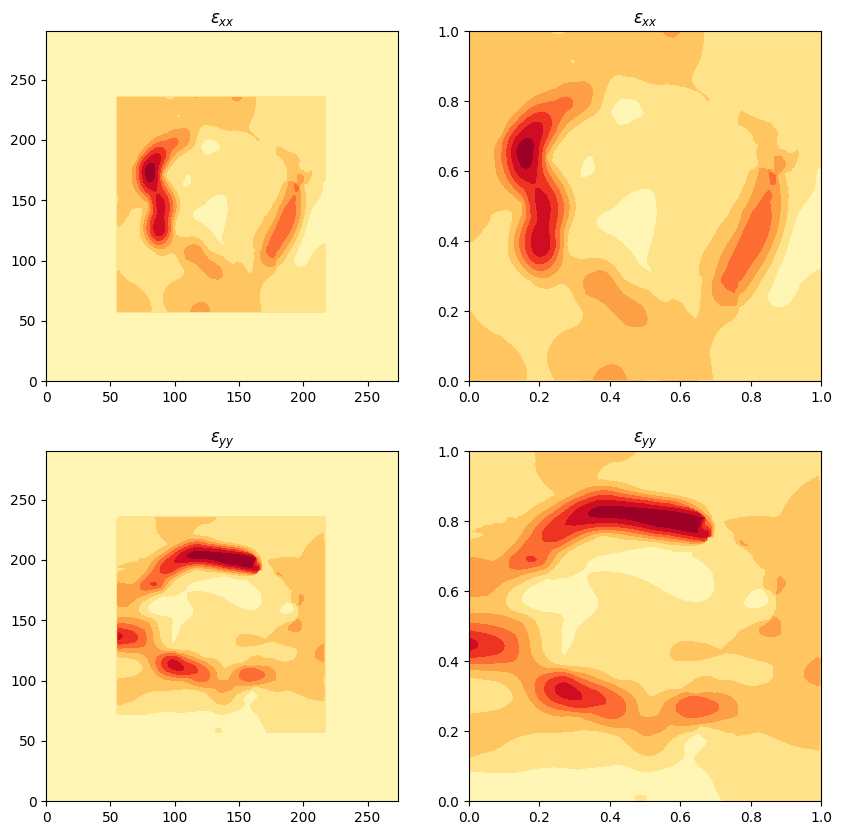

In [10]:
f = scipy.io.loadmat('data/PU1_034_3/NEWLYFIXED_PU1_034_3.mat')
i1 = 57
i2 = 236
i3 = 55
i4 = 218
nx = i4-i3
ny = i2-i1

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
x, y = np.meshgrid(x,y)

epsx = np.zeros([50,ny,nx])
epsy = np.zeros([50,ny,nx])
aux1 = np.zeros([50,291,275])
aux2 = np.zeros([50,291,275])
for i in range(50):
    aux1[i] = f['data_dic_save']['strains'][0,0][0,i][0]
    aux2[i] = f['data_dic_save']['strains'][0,0][0,i][2]
    epsx[i] = aux1[i][i1:i2, i3:i4]
    epsy[i] = aux2[i][i1:i2, i3:i4]

t = 49
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].contourf(aux1[t], cmap='YlOrRd')
ax[0,1].contourf(x,y,epsx[t], cmap='YlOrRd')
ax[0,0].set(title='$\epsilon_{xx}$')
ax[0,1].set(title='$\epsilon_{xx}$')

ax[1,0].contourf(aux2[t], cmap='YlOrRd')
ax[1,1].contourf(x,y,epsy[t], cmap='YlOrRd')
ax[1,0].set(title='$\epsilon_{yy}$')
ax[1,1].set(title='$\epsilon_{yy}$')

lmx = 10868/9252 # = 1.1746
lmy = 12077/10252 # = 1.1780

In [4]:
node_X = np.array([x.flatten(), y.flatten()]).T
t = 49 #time step
strains = np.array([epsx[49].flatten(), epsy[49].flatten()])

In [9]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss(params, X, key):
    inp, out_gt = X[:,:2], X[:,2:]
    out_pr = ff_nn(inp, params)
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 10 # 10 cosines and 10 sines in the fourier features
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,10,10,2]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(1.e-2)
opt_state = opt_init(coord_2_strain_params)

inp = np.hstack([node_X, strains.T])
coord_2_strain_params, train_loss, _ = train_jp(loss, inp, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, batch_size=500)

it 1000, train loss = 1.711810e-03
it 2000, train loss = 1.262110e-03
it 3000, train loss = 1.162889e-03
it 4000, train loss = 1.137818e-03
it 5000, train loss = 1.024083e-03
it 6000, train loss = 1.074688e-03
it 7000, train loss = 9.516270e-04
it 8000, train loss = 9.921463e-04
it 9000, train loss = 9.797368e-04
it 10000, train loss = 9.945828e-04


In [10]:
epsx_pr, epsy_pr = ff_nn(inp[:,:2], coord_2_strain_params).T

In [11]:
epsx_pr = epsx_pr.reshape([epsx.shape[1], epsx.shape[2]])
epsy_pr = epsy_pr.reshape([epsy.shape[1], epsy.shape[2]])

[Text(0.5, 1.0, '$\\epsilon_{yy}$')]

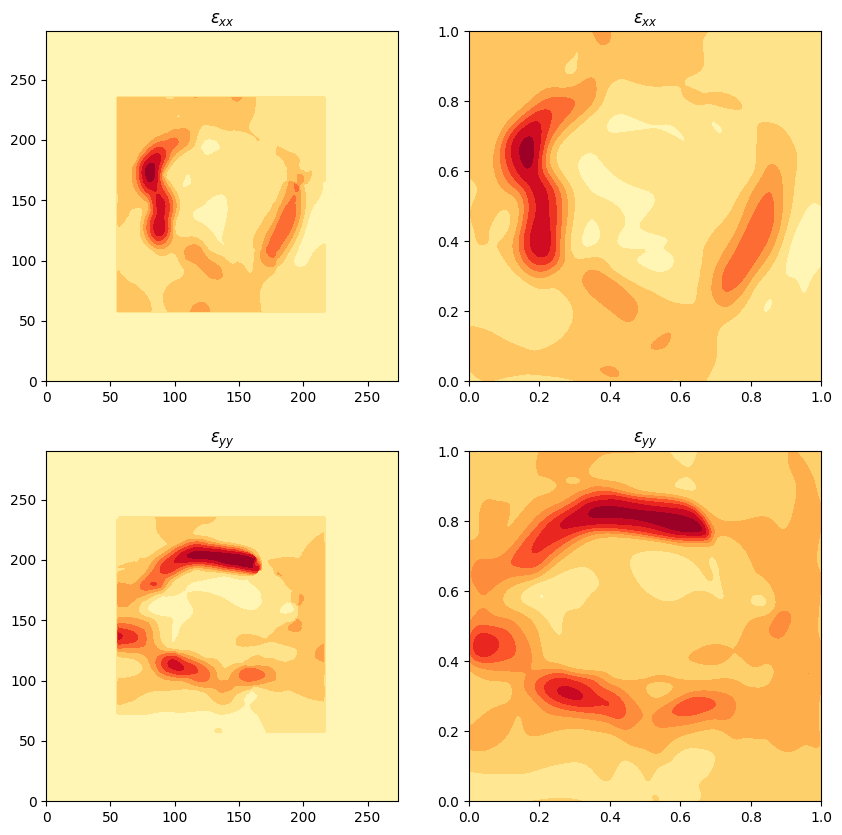

In [12]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].contourf(aux1[t], cmap='YlOrRd')
ax[0,1].contourf(x,y,epsx_pr, cmap='YlOrRd')
ax[0,0].set(title='$\epsilon_{xx}$')
ax[0,1].set(title='$\epsilon_{xx}$')

ax[1,0].contourf(aux2[t], cmap='YlOrRd')
ax[1,1].contourf(x,y,epsy_pr, cmap='YlOrRd')
ax[1,0].set(title='$\epsilon_{yy}$')
ax[1,1].set(title='$\epsilon_{yy}$')

In [13]:
nrow = 40
ncol = 40
n_node = nrow*ncol
n_elem = n_node-nrow-ncol+1
pts_x = np.linspace(0,1,nrow)
pts_y = np.linspace(0,1,ncol)
node_X, node_Y = np.meshgrid(pts_x,pts_y)
node_X = np.vstack((node_Y.flatten(), node_X.flatten())).T

# Identify the boundary nodes
rgt_bd = np.where(node_X[:,0]>0.99)
top_bd = np.where(node_X[:,1]>0.99)
lft_bd = np.where(node_X[:,0]<0.01)
bot_bd = np.where(node_X[:,1]<0.01)
rgt_bd_x = node_X[rgt_bd,0].flatten()
rgt_bd_y = node_X[rgt_bd,1].flatten()
top_bd_x = node_X[top_bd,0].flatten()
top_bd_y = node_X[top_bd,1].flatten()
lft_bd_x = node_X[lft_bd,0].flatten()
lft_bd_y = node_X[lft_bd,1].flatten()
bot_bd_x = node_X[bot_bd,0].flatten()
bot_bd_y = node_X[bot_bd,1].flatten()

rgt_bd_X = np.array([rgt_bd_x, rgt_bd_y]).T
top_bd_X = np.array([top_bd_x, top_bd_y]).T
lft_bd_X = np.array([lft_bd_x, lft_bd_y]).T
bot_bd_X = np.array([bot_bd_x, bot_bd_y]).T

elements = np.zeros((n_elem, 4), dtype=np.int_)

i=0
j=0
while i < n_node - ncol: #exclude 1 row at the top because there are no nodes above those to form elements.
    if (i+1)%ncol != 0: #Skip the nodes on the right
        elements[j,0] = i
        elements[j,3] = i+1
        elements[j,2] = i+ncol + 1
        elements[j,1] = i+ncol
        j+= 1
    i+= 1

Fx = 1.0
Fy = 1.0

In [14]:
# Homogenize the strains
epsx_mean = np.mean(strains[0])
epsy_mean = np.mean(strains[1])
sgmx_mean = Fx/nrow
sgmy_mean = Fy/ncol
lamb_sigma_m = np.array([epsx_mean+1.0, epsy_mean+1.0, sgmx_mean, sgmy_mean]).reshape([1,-1])

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, key):
    model   = NODE_model_aniso(params)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sgmx_gt  = lamb_sigma[:,2]
    sgmy_gt  = lamb_sigma[:,3]
    sgm = eval_Cauchy_aniso_vmap(lambx,lamby, model)
    sgmx_pr, sgmy_pr = sgm[:,0,0], sgm[:,1,1]
    return np.mean((sgmx_pr-sgmx_gt)**2+(sgmy_pr-sgmy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train_jp(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000)

it 1000, train loss = 2.150618e-01
it 2000, train loss = 2.899295e-02
it 3000, train loss = 7.898986e-03
it 4000, train loss = 2.720076e-03
it 5000, train loss = 1.001906e-03
it 6000, train loss = 3.581564e-04
it 7000, train loss = 1.134391e-04
it 8000, train loss = 2.814783e-05
it 9000, train loss = 4.456334e-06
it 10000, train loss = 3.102076e-07


In [15]:
mymodel = NODE_model_aniso(node_params)
sgm = eval_Cauchy_aniso(epsx_mean+1.0,epsy_mean+1.0, mymodel)
sgmx, sgmy = sgm[0,0], sgm[1,1]
print('gt sgmx & sgmy: ', sgmx_mean, sgmy_mean)
print('pr sgmx & sgmy: ', sgmx, sgmy)

gt sgmx & sgmy:  0.025 0.025
pr sgmx & sgmy:  0.025424822426751138 0.02536018533333546


In [16]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

ff_params = coord_2_strain_params[0]
ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn2(inp, params)
    return jnp.mean((out_pr-phi)**2)

# n_ff = 10
# ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,40,40,n_phi]
Lambda_params = init_params_nn(nn_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train_jp(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 2000, print_freq=1000)

it 1000, train loss = 1.474254e-03
it 2000, train loss = 2.959457e-04


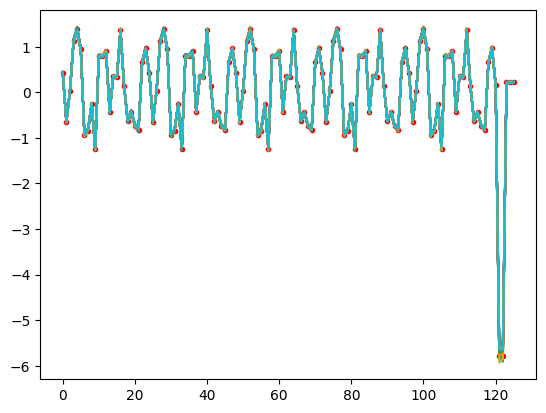

In [18]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn2(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [19]:
with open('params/PU1_034_3_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, node_X, elements, n_node, n_elem, Fx, Fy, strains,
                 rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X], f)

In [34]:
with open('params/PU1_034_3_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, node_X, elements, n_node, n_elem, Fx, Fy, strains, \
        rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X = pickle.load(f)
_, unravel = ravel_pytree(node_params)

In [ ]:
ff_params = coord_2_strain_params[0]
ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
# Train with the heterogeneity
def get_stresses(x, y, Lambda_params):
    epsx, epsy = ff_nn(jnp.array([x,y]), coord_2_strain_params).T

    # get NODE individual-specific params, phi, from the Lambda NN
    Lambda_inp = jnp.array([x,y]).reshape([-1,2])
    phi = ff_nn2(Lambda_inp, Lambda_params).flatten()
    # Make predictions with this NODE
    mymodel = NODE_model_aniso(unravel(phi))
    sgm = eval_Cauchy_aniso(epsx+1.0,epsy+1.0, mymodel)
    return sgm[0,0], sgm[1,0], sgm[0,1], sgm[1,1]
get_stresses_vmap = vmap(get_stresses, in_axes=(0,0,None), out_axes=(0,0,0,0))

get_sgm_xx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[0]
get_sgm_yx = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[1]
get_sgm_xy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[2]
get_sgm_yy = lambda x, y, Lambda_params: get_stresses(x, y, Lambda_params)[3]

grad_sgm_xx_x = vmap(grad(get_sgm_xx, argnums=0), in_axes=(0,0,None), out_axes=0) # should return dsgm_xx/dx
grad_sgm_yx_x = vmap(grad(get_sgm_yx, argnums=0), in_axes=(0,0,None), out_axes=0)
grad_sgm_xy_y = vmap(grad(get_sgm_yx, argnums=1), in_axes=(0,0,None), out_axes=0)
grad_sgm_yy_y = vmap(grad(get_sgm_yy, argnums=1), in_axes=(0,0,None), out_axes=0)

@jit
def bd_forces(Lambda_params, input):
    rgt_bd_sgm = get_stresses_vmap(rgt_bd_X[:,0], rgt_bd_X[:,1], Lambda_params)
    top_bd_sgm = get_stresses_vmap(top_bd_X[:,0], top_bd_X[:,1], Lambda_params)
    lft_bd_sgm = get_stresses_vmap(lft_bd_X[:,0], lft_bd_X[:,1], Lambda_params)
    bot_bd_sgm = get_stresses_vmap(bot_bd_X[:,0], bot_bd_X[:,1], Lambda_params)

    rgt_bd_frc = jnp.sum(rgt_bd_sgm[0]) # Assume area of edge = 1.0
    top_bd_frc = jnp.sum(top_bd_sgm[3])
    lft_bd_frc = jnp.sum(lft_bd_sgm[0])
    bot_bd_frc = jnp.sum(bot_bd_sgm[3])
    return rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc
@jit
def divergence(Lambda_params, X_colloc):
    # X_colloc = random.uniform(key, (500,2))
    dsgm_xx_dx = grad_sgm_xx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_xy_dy = grad_sgm_xy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yx_dx = grad_sgm_yx_x(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    dsgm_yy_dy = grad_sgm_yy_y(X_colloc[:,0], X_colloc[:,1], Lambda_params)
    
    div_x = jnp.mean(dsgm_xx_dx + dsgm_xy_dy) # = dsgm_xx/dx + dsgm_xy/dy
    div_y = jnp.mean(dsgm_yx_dx + dsgm_yy_dy) # = dsgm_yx/dx + dsgm_yy/dy
    return div_x, div_y
@jit
def loss(Lambda_params, X_colloc):
    div_x, div_y = divergence(Lambda_params, X_colloc)
    rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc = bd_forces(Lambda_params, None)
    a1 = 500.0
    a2 = 1.0
    return a1*(div_x**2 + div_y**2) + a2*((rgt_bd_frc-Fx)**2 + (top_bd_frc-Fy)**2 + (lft_bd_frc-Fx)**2 + (bot_bd_frc-Fy)**2)

@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    val_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        X_colloc = random.uniform(key, (500,2))
        opt_state = step(loss, it, get_params, opt_update, opt_state, X_colloc)
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            val_loss_value = loss(params, X)
            val_loss.append(val_loss_value)
            if metric_fns is not None:
                m = []
                for metric_fn in metric_fns:
                    m.append(metric_fn(params, X))
                metrics.append(m)
            to_print = "it %i, val loss = %e" % (it+1, val_loss_value)
            print(to_print)
    return get_params(opt_state), val_loss, metrics

opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 5.e-4
opt_state = opt_init(Lambda_params)
Lambda_params, val_loss, metrics = train(loss, node_X, get_params, opt_update, opt_state, 
                                              key, nIter = 100_000, print_freq=1000, metric_fns=[bd_forces, divergence])
# with open('params/PU1_034_3_post.npy', 'wb') as f:
#     pickle.dump([node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics], f)

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_86816/1681094404.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  forces, div = np.array(metrics).T


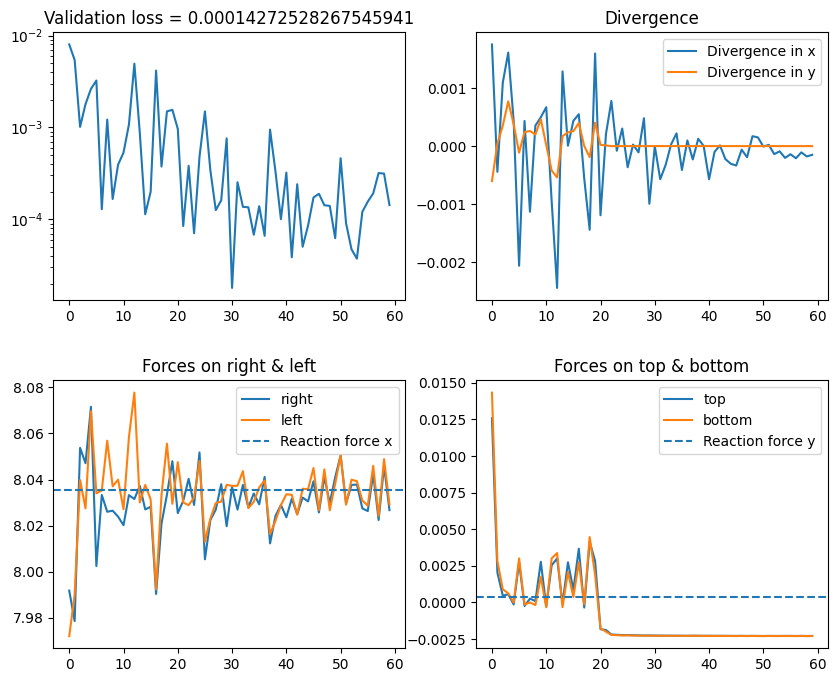

In [6]:
forces, div = np.array(metrics).T
forces = np.array([*forces])
div = np.array([*div])

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx, linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy, linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

In [13]:
with open('params/PU1_034_3_post.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)
n_node = len(node_X)

In [14]:
class NODE_SEDF_aniso():
    def __init__(self, Lambda_params=None, unravel=None):
        self.Lambda_params = Lambda_params
        self.unravel = unravel
        return
    def nn_fpass(self, H, params):
        Ws, bs = params
        N_layers = len(Ws)
        for i in range(N_layers - 1):
            H = jnp.matmul(H, Ws[i]) + bs[i]
            H = jnp.tanh(H)
        H = jnp.matmul(H, Ws[-1]) + bs[-1]
        return H
    def X2params(self, X):
        Lambda_inp = np.array([X[0],X[1]]).reshape([-1,2])
        phi = self.nn_fpass(Lambda_inp, self.Lambda_params).flatten()
        params = self.unravel(phi)
        return params
    def fiberangle(self, node_X):
        return 0.0
    
    def Psi_i(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        Psi1 = model.Psi1(I1,I2,Iv,Iw)
        Psi2 = model.Psi2(I1,I2,Iv,Iw)
        Psiv = model.Psiv(I1,I2,Iv,Iw)
        Psiw = model.Psiw(I1,I2,Iv,Iw)
        return Psi1, Psi2, Psiv, Psiw

    def Psi_ii(self, I1, I2, Iv, Iw, X):
        params = self.X2params(X)
        model = NODE_model_aniso(params)
        
        e = 1.0e-6
        Psi1_p = model.Psi1(I1+e,I2,Iv,Iw)
        Psi1_m = model.Psi1(I1-e,I2,Iv,Iw)
        Psi2_p = model.Psi2(I1+e,I2,Iv,Iw)
        Psi2_m = model.Psi2(I1-e,I2,Iv,Iw)
        Psiv_p = model.Psiv(I1+e,I2,Iv,Iw)
        Psiv_m = model.Psiv(I1-e,I2,Iv,Iw)
        Psiw_p = model.Psiw(I1+e,I2,Iv,Iw)
        Psiw_m = model.Psiw(I1-e,I2,Iv,Iw)
        Psi11 = (Psi1_p-Psi1_m)/2/e
        Psi12 = (Psi2_p-Psi2_m)/2/e
        Psi1v = (Psiv_p-Psiv_m)/2/e
        Psi1w = (Psiw_p-Psiw_m)/2/e

        Psi2_p = model.Psi2(I1,I2+e,Iv,Iw)
        Psi2_m = model.Psi2(I1,I2-e,Iv,Iw)
        Psiv_p = model.Psiv(I1,I2+e,Iv,Iw)
        Psiv_m = model.Psiv(I1,I2-e,Iv,Iw)
        Psiw_p = model.Psiw(I1,I2+e,Iv,Iw)
        Psiw_m = model.Psiw(I1,I2-e,Iv,Iw)
        Psi22 = (Psi2_p-Psi2_m)/2/e
        Psi2v = (Psiv_p-Psiv_m)/2/e
        Psi2w = (Psiw_p-Psiw_m)/2/e

        Psiv_p = model.Psiv(I1,I2,Iv+e,Iw)
        Psiv_m = model.Psiv(I1,I2,Iv-e,Iw)
        Psiw_p = model.Psiw(I1,I2,Iv+e,Iw)
        Psiw_m = model.Psiw(I1,I2,Iv-e,Iw)
        Psivv = (Psiv_p-Psiv_m)/2/e
        Psivw = (Psiw_p-Psiw_m)/2/e

        Psiw_p = model.Psiw(I1,I2,Iv,Iw+e)
        Psiw_m = model.Psiw(I1,I2,Iv,Iw-e)
        Psiww = (Psiw_p-Psiw_m)/2/e
        return Psi11, Psi22, Psivv, Psiww, Psi12, Psi1v, Psi1w, Psi2v, Psi2w, Psivw

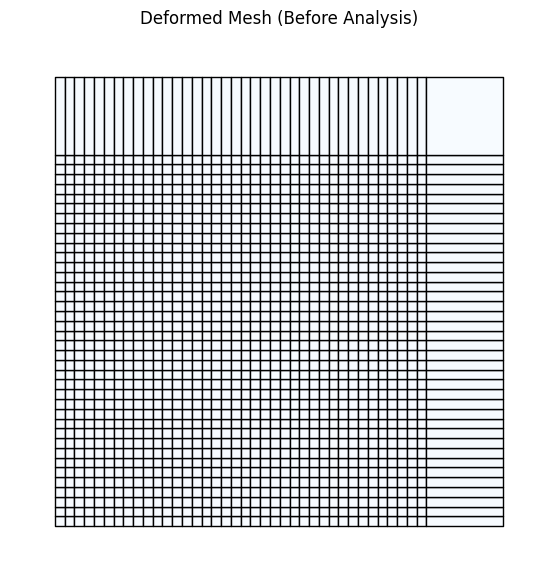

In [30]:
node_x = np.zeros_like(node_X)
DOF_fmap = np.zeros((n_node,2),dtype=int)
dof = 0
for i in range(n_node):
    X = node_X[i]
    node_x[i] = node_X[i]
    if X[0]<0.001 and X[1]<0.001: #lower left corner
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
        node_x[i,0] = 0
        node_x[i,1] = 0
    elif X[0]>0.999 and X[1]<0.001: #lower right corner
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
        node_x[i,0] = lmx
        node_x[i,1] = 0
    elif X[0]>0.999 and X[1]>0.999: #upper right corner
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
        node_x[i,0] = lmx
        node_x[i,1] = lmy
    elif X[0]<0.001 and X[1]>0.999: #upper left corner
        DOF_fmap[i,0] = -1
        DOF_fmap[i,1] = -1
        node_x[i,0] = 0
        node_x[i,1] = lmy
    elif X[0]<0.001: #The rest of the left boundary
        DOF_fmap[i,0] = -1
        node_x[i,0] = 0
        DOF_fmap[i,1] = dof
        dof+= 1
    elif X[1]<0.001: #The rest of the lower boundary
        DOF_fmap[i,1] = -1
        node_x[i,1] = 0
        DOF_fmap[i,0] = dof
        dof+= 1
    elif X[0]>0.999: #The rest of the right boundary
        DOF_fmap[i,0] = -1
        node_x[i,0] = lmx
        DOF_fmap[i,1] = dof
        dof+= 1
    elif X[1]>0.999: #The rest of the upper boundary
        DOF_fmap[i,1] = -1
        node_x[i,1] = lmy
        DOF_fmap[i,0] = dof
        dof+= 1
    else: #The rest of the domain
        DOF_fmap[i,0] = dof
        dof+=1
        DOF_fmap[i,1] = dof
        dof+=1
plotmesh(elements, node_x, c=np.ones([node_X.shape[0]]), title='Deformed Mesh (Before Analysis)', cbar = False); 

In [ ]:
mySEDF = NODE_SEDF_aniso(Lambda_params, unravel)
const_model = vahid_anisohyper_inv(mySEDF)
mysolver = fe_solver_2D(node_X, node_x, elements, DOF_fmap, const_model)
mysolver.n_print = 1
mysolver.itermax = 20
node_x, F, sigma = mysolver.solve()

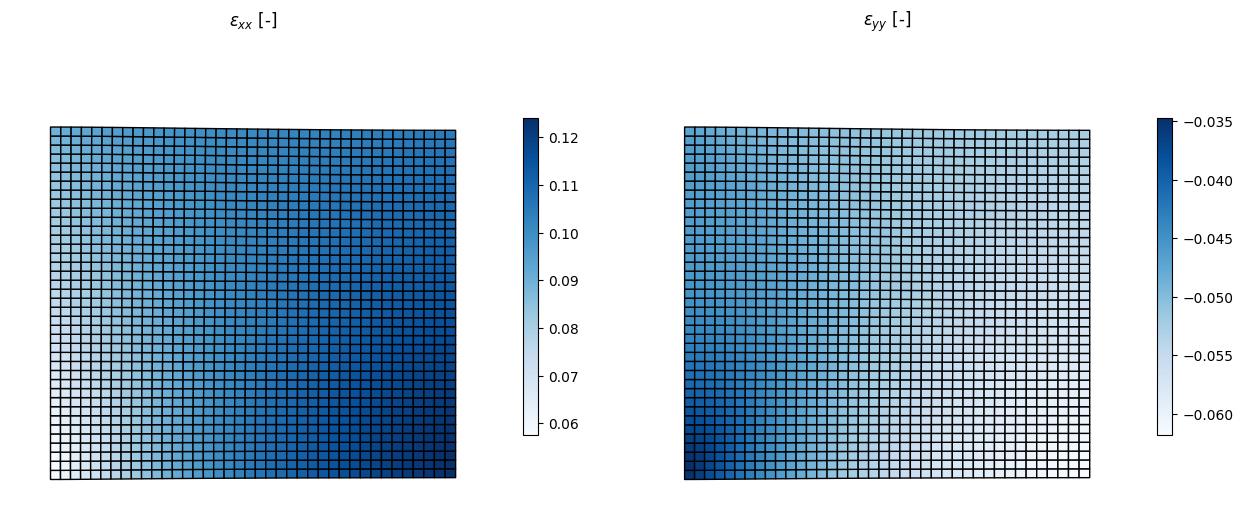

In [16]:
fig, axes = plt.subplots(1,2,figsize=(15,7))
plotmesh(elements, node_x, F[:,0,0]-1.0, title='$\epsilon_{xx}$ [-]', ax=axes[0]); 
plotmesh(elements, node_x, F[:,1,1]-1.0, title='$\epsilon_{yy}$ [-]', ax=axes[1]); 

#### Write abaqus input file

In [3]:
with open('params/PU1_034_3_post.npy', 'rb') as f:
    node_X, strains, Fx, Fy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)
write_biax_abaqus_inp(Lambda_params, nn_fpass, node_params, Fx, Fy, outputfile='abaqus/PU1_034_3.inp')